# Model Validation and Data Leakage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, make_scorer

from useful_functions import *

%load_ext autoreload
%autoreload 2

<code>ss = StandardScaler()  
ss.fit(X_train)  
ss.transform(X_train)</code> 

**what is done to training must also be done to test**
 
<code>ss.transform(X_test)</code>  
 - we don't do .fit() on test 
 

---

Overfitting data:  

Train .score() - R^2 = 96.6%, RMSE = 8.8  
Test .score() - R^2 = 50%, RMSE = 52.5  

Underfitting data (high bias):

Train - R^2 = 10% (bad)  
Test - R^2 = 12% (also bad)  

---

## Objectives

- explain the bias-variance tradeoff and the correlative notions of underfit and overfit models
- describe a train-test split and explain its purpose in the context of predictive statistics / machine learning
- explain the algorithm of cross-validation
- use best practices for building non-leaky workflows
- repair leaky workflows

## Motivation

At this point, we have seen different ways to create models from our data through different linear regression techniques. That's good. But when it comes to measuring model performance, we also want to make sure that our models are ready to predict on data that they haven't seen yet.

Usually, when our model is ready to be used in the "real world" we refer to this as putting our model into **production** or **deploying** our model. The data points for which it will make predictions will be data *it has never seen before*, as opposed to the data points that were used to train the model.

This is where ***model validation*** techniques come in, namely, to ensure our model can *generalize* to data it hasn't directly seen before.

As a way into a discussion of these techniques let's say a word about the **bias-variance tradeoff**.

## The Bias-Variance Tradeoff

We can break up how the model makes mistakes (the error) by saying there are three parts:

- Error inherent in the data (noise): **irreducible error**
- Error from not capturing signal (too simple): **bias**
- Error from "modeling noise", i.e. capturing patterns in the data that don't generalize well (too complex): **variance**

We can summarize this in an equation for the _mean squared error_ (MSE):

$MSE = Bias(\hat{y})^2 + Var(\hat{y}) + \sigma^2$

![optimal](images/optimal_bias_variance.png)
http://scott.fortmann-roe.com/docs/BiasVariance.html

### Bias

**High-bias** algorithms tend to be less complex, with simple or rigid underlying structure.

![](images/noisy-sine-linear.png)

+ They train models that are consistent, but inaccurate on average.
+ These include linear or parametric algorithms such as regression and naive Bayes.
+ The following sorts of difficulties could lead to high bias:
  - We did not include the correct predictors
  - We did not take interactions into account
  - We missed a non-linear (polynomial) relationship

      
High-bias models are generally **underfit**: The models have not picked up enough of the signal in the data. And so even though they may be consistent, they don't perform particularly well on the initial data, and so they will be consistently inaccurate.

### Variance

On the other hand, **high-variance** algorithms tend to be more complex, with flexible underlying structure.

![](images/noisy-sine-decision-tree.png)

+ They train models that are accurate on average, but inconsistent.
+ These include non-linear or non-parametric algorithms such as decision trees and nearest-neighbor models.
+ The following sorts of difficulties could lead to high variance:
  - We included an unreasonably large number of predictors;
  - We created new features by squaring and cubing each feature.

High variance models are **overfit**: The models have picked up on the noise as well as the signal in the data. And so even though they may perform well on the initial data, they will be inconsistently accurate on new data.

### Balancing Bias and Variance

While we build our models, we have to keep this relationship in mind.  If we build complex models, we risk overfitting our models.  Their predictions will vary greatly when introduced to new data.  If our models are too simple, the predictions as a whole will be inaccurate.   

![](images/noisy-sine-third-order-polynomial.png)

The goal is to build a model with enough complexity to be accurate, but not too much complexity to be erratic.

## Different Models for Diabetes Data

In [3]:
data = load_diabetes()

print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [4]:
df = pd.concat([pd.DataFrame(data.data, columns=data.feature_names),
               pd.Series(data.target, name='target')], axis=1)

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


Let's take a random data point that we can use for prediction. Note the trained model will never see this point until after it's done training.

In [5]:
# For consistent randomness
np.random.seed(42)

my_sample = df.sample(1)
my_sample_target = my_sample.iloc[0, -1]
my_sample_pt = my_sample.drop('target', axis=1)

# Show my random sample off
print(f'Target value of sample: {my_sample_target}')
my_sample_pt

Target value of sample: 219.0


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
287,0.045341,-0.044642,-0.006206,-0.015999,0.125019,0.125198,0.019187,0.034309,0.032433,-0.00522


### Simpler Model

Now let's generate random subsets of our data now to train different models and see how well they do in predicting  that random point. The `train_lr_randomly()` function was  built to do this for us.

In [6]:
# Run 1000 linear regression trainings on some random data from df and compare
# it with the random sample point
r2_simple, rmse_simple, pt_preds_simple = train_lr_randomly(
                                                        data=df.drop(my_sample_pt.index[0]), 
                                                        sample_pt=my_sample_pt,
                                                        ntimes=1000
)

D:\Documents\anaconda3\envs\learn-env\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 9.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


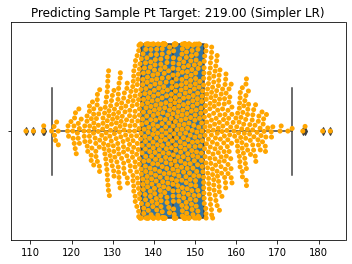

In [7]:
plot_model_predictions(predictions=pt_preds_simple, my_sample_target=my_sample_target);

- this has decently low variance, but high bias. centered at 140-150 instead of 219

### More Complex Model

Now let's see how we do with a more complex model (using polynomial features):

In [8]:
pf = PolynomialFeatures(3, interaction_only=True) # What if we used 3 or 4?

df_pf = pd.DataFrame(pf.fit_transform(df.drop('target', axis=1)))
df_pf.index = df.index
df_pf['target'] = df['target']

cols = list(df_pf)

# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('target')))

df_pf = df_pf.loc[:, cols]

In [9]:
# Let's make sure we have another sample point to test our models.
# We'll just transform our original sample point.

my_sample_pt_poly = pf.transform(my_sample_pt)
my_sample_pt_poly = pd.DataFrame(my_sample_pt_poly,
                                index=my_sample_pt.index)

# Show my random sample off
print(f'Target value of sample: {my_sample_target}')
my_sample_pt_poly.shape

Target value of sample: 219.0


(1, 176)

In [10]:
# Run 1000 linear regression trainings on some random polynomial features data
# from df_poly and compare it with the random sample point
r2_poly, rmse_poly, pt_preds_poly = train_lr_randomly(
                                                data=df_pf.drop(my_sample_pt_poly.index[0]), 
                                                sample_pt=my_sample_pt_poly,
                                                ntimes=1000
)

D:\Documents\anaconda3\envs\learn-env\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 44.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
D:\Documents\anaconda3\envs\learn-env\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 52.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


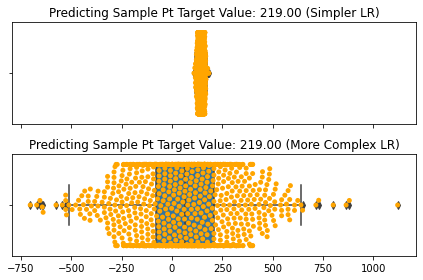

In [11]:
plot_model_predictions(predictions=pt_preds_simple,
                       my_sample_target=my_sample_target,
                       second_predictions=pt_preds_poly)

- this has higher accuracy, but way higher variance.
- low bias

In [12]:
print('How it did on its own training data:')
print(f'\t- simple model mean RMSE {np.mean(rmse_simple)}')
print(f'\t- complex model mean RMSE {np.mean(rmse_poly)}')
print('\n')

print('How it did on data it never saw:')
print(f'\t- simple model predictions\' std {np.std(pt_preds_simple)}')
print(f'\t- complex model predictions\' std {np.std(pt_preds_poly)}')

How it did on its own training data:
	- simple model mean RMSE 52.45161473022164
	- complex model mean RMSE 42.433703715991


How it did on data it never saw:
	- simple model predictions' std 11.337957165961475
	- complex model predictions' std 231.4898155845214


## 🧠 Knowledge Check

![which_model](images/which_model_is_better_2.png)

## Train-Test Split

It is hard to know if your model is too simple or complex by just using it on training data.

We can _hold out_ part of our training sample, use it as a test sample, and then use it to monitor our prediction error.

This allows us to evaluate whether our model has the right balance of bias/variance. 

<img src='images/testtrainsplit.png' width =550 />

* **training set** —a subset to train a model.
* **test set**—a subset to test the trained model.

## Is the Model Overfitting or Underfitting?

If our model is not performing well on the training  data, we are probably underfitting it.  

To know if our  model is overfitting the data, we need  to test our model on unseen data. 
We then measure our performance on the unseen data. 

If the model performs significantly worse on the  unseen data, it is probably  overfitting the data.

<img src='https://developers.google.com/machine-learning/crash-course/images/WorkflowWithTestSet.svg' width=500/>

## Practice Exercises: Name that Model!

Consider the following scenarios and describe them according to bias and variance. There are four possibilities:

- a. The model has low bias and high variance.
- b. The model has high bias and low variance.
- c. The model has both low bias and low variance.
- d. The model has both high bias and high variance.

**Scenario 1**: The model has a low RMSE on training and a low RMSE on test.
<details>
    <summary> Answer
    </summary>
    c. The model has both low bias and low variance.
    </details>

**Scenario 2**: The model has a high $R^2$ on the training set, but a low $R^2$ on the test.
<details>
    <summary> Answer
    </summary>
    a. The model has low bias and high variance.
    </details>

**Scenario 3**: The model performs well on data it is fit on and well on data it has not seen.
<details>
    <summary> Answer
    </summary>
    c. The model has both low bias and low variance.
    </details>
  

**Scenario 4**: The model has a low $R^2$ on training but high on the test set.
<details>
    <summary> Answer
    </summary>
    d. The model has both high bias and high variance.
    </details>

**Scenario 5**: The model leaves out many of the meaningful predictors, but is consistent across samples.
<details>
    <summary> Answer
    </summary>
    b. The model has high bias and low variance.
    </details>

**Scenario 6**: The model is highly sensitive to random noise in the training set.
<details>
    <summary> Answer
    </summary>
    a. The model has low bias and high variance.
    </details>

## Should You Ever Fit on Your Test Set?  

![no](https://media.giphy.com/media/d10dMmzqCYqQ0/giphy.gif)

**Never fit on test data.** If you are seeing surprisingly good results on your evaluation metrics, it might be a sign that you are accidentally training on the test set.

## Train-Test Split Our Earlier Example

In [13]:
df.corr()['target'].map(abs).sort_values(ascending=False)

target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441484
s4        0.430453
s3        0.394789
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
Name: target, dtype: float64

In [14]:
X = df[['bmi', 's5']]
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=None,
                                                    random_state=2022
)

In [15]:
display(X_train.head())
display(X_test.head())

,bmi,s5
258,-0.024529,-0.037128
75,-0.030996,0.006209
239,0.019662,0.066048
425,-0.040696,-0.020289
406,-0.080575,-0.056158


,bmi,s5
41,-0.067641,-0.049868
93,-0.064408,-0.033249
141,0.047685,0.045066
379,-0.038540,-0.046879
342,0.021817,-0.023645


In [16]:
print(X_train.shape)
print(X_test.shape)

(331, 2)
(111, 2)


In [17]:
print(X_train.shape[0] == y_train.shape[0])
print(X_test.shape[0] == y_test.shape[0])

True
True


In [18]:
# Instanstiate your linear regression object
lr = LinearRegression()

In [19]:
# fit the model on the training set
lr.fit(X_train, y_train)

LinearRegression()

In [20]:
# Check the R^2 of the training data
lr.score(X_train, y_train)

0.4460937122654338

In [21]:
lr.coef_

array([653.26219487, 634.01957601])

A .446 R-squared reflects a model that explains about half of the total variance in the data. 

## Now check performance on test data

Next, we test how well the model performs on the unseen test data. Remember, we do not fit the model again. The model has calculated the optimal parameters learning from the training set.  

In [22]:
lr.score(X_test, y_test)

0.49498529072233477

## 🧠 Knowledge Check

How would you describe the bias of the model based on the above training $R^2$?

<details>
    <summary> Answer
    </summary>
    The difference between the train and test scores is low.
    </details>

What does that indicate about variance?

## Same Procedure with a Polynomial Model

In [ ]:
poly_2 = PolynomialFeatures(4)

X_poly = pd.DataFrame(
            poly_2.fit_transform(df.drop('target', axis=1))
                      )

y = df.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y,
                                                    test_size=0.2,
                                                    random_state=42)
lr_poly = LinearRegression()

# Always fit on the training set
lr_poly.fit(X_train, y_train)

lr_poly.score(X_train, y_train)

In [ ]:
lr_poly.score(X_test, y_test)

## Exercise

[This post about scaling and data leakage](https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data) explains that if you are going to scale your data, you should only train your scaler on the training data to prevent data leakage.  

Perform the same train-test split as shown above for the simple model, but now scale your data appropriately.  

The $R^2$ for both train and test should be the same as before.

In [ ]:
np.random.seed(42)

y = df.target
X = df[['bmi', 's5']]

# Train test split with random_state=42 and test_size=0.2

# Create (reasonable) polynomial features

# Scale appropriately

# fit and score the model (checkout the test set if there is time)


<details>
    <summary>Answer</summary>
<code>np.random.seed(42)
y = df.price
X = df[['bedrooms', 'sqft_living']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
pf = PolynomialFeatures(1).fit(X_train)
pf_train = pf.transform(X_train)
ss = StandardScaler().fit(pf_train)
train_scld = ss.transform(pf_train)
lr = LinearRegression().fit(train_scld, y_train)
print(lr.score(train_scld, y_train))
pf_test = pf.transform(X_test)
test_scld = ss.transform(pf_test)
print(lr.score(test_scld, y_test))
</code>
    </details>

## Data Leakage

We have encountered the idea of splitting our data into two, *training* our model on one bit and then *testing* it on the other.

The goal is to have an unbiased assessment of our model, and so we want to make sure that nothing about our test data sneaks into the training run of the model.

### A Mistake

Now consider the following workflow:

In [23]:
df = pd.concat([pd.DataFrame(data.data, columns=data.feature_names),
               pd.Series(data.target, name='target')], axis=1)

df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [24]:
X, y = load_diabetes(return_X_y=True)

In [25]:
ss = StandardScaler().fit(X)
X_scld = ss.transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_scld, y, random_state=42)

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.coef_, lr.intercept_)

[  2.27107279 -11.5103763   25.30316447  18.14921047 -43.68812386
  24.17505729   5.56228784  12.81809837  33.09612684   1.25207795] 151.66516982689885


Well we fit the model only to our training data. Looks like we've done everything right, right?

It's important to understand that the answer here is a resounding "NO". It's true that we didn't directly fit our model to our test data. But the trouble is that we fit our scaler **to the whole dataset**. That is, records in the test data are contributing to calculations of column means and standard deviations, and so, surreptitiously, information about our test set is sneaking into the training run of the model after all!

To correct our mistake, we'll make sure to perform our train-test split **first**:

In [28]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state=42)

In [29]:
ss2 = StandardScaler().fit(X_train2)
X_train2_scld = ss2.transform(X_train2)
X_test2_scld = ss2.transform(X_test2)

In [30]:
lr2 = LinearRegression()
lr2.fit(X_train2_scld, y_train2)
print(lr2.coef_, lr2.intercept_)

[  2.21493322 -11.51452473  25.07685109  18.24943843 -44.14403151
  24.5135485    5.4971345   13.00640779  33.3797142    1.24791796] 154.34441087613294


Note that our model coefficients are slightly different from what they were before.

#### Error Comparison

It's worth pointing out that, **for linear models**, there is **no** difference in modeling error:

In [31]:
y_test_hat = lr.predict(X_test)
mse = mean_squared_error(y_test, y_test_hat)
print(f"Our test RMSE for this model is {round(np.sqrt(mse), 2)}.")

Our test RMSE for this model is 53.37.


In [32]:
y_test2_hat = lr2.predict(X_test2_scld)
mse = mean_squared_error(y_test2, y_test2_hat)
print(f"Our test RMSE for this model is {round(np.sqrt(mse), 2)}.")

Our test RMSE for this model is 53.37.


This will **not** be true for other sorts of models that use different loss functions.

### Preprocessing

In general all preprocessing steps are subject to the same dangers here. Consider the preprocessing step of one-hot-encoding:

In [33]:
gun_poll = pd.read_csv('data/guns-polls.csv')

gun_poll.head()

,Question,Start,End,Pollster,Population,Support,Republican Support,Democratic Support,URL
0,age-21,2/20/18,2/23/18,CNN/SSRS,Registered Voters,72,61,86,http://cdn.cnn.com/cnn/2018/images/02/25/rel3a...
1,age-21,2/27/18,2/28/18,NPR/Ipsos,Adults,82,72,92,https://www.ipsos.com/en-us/npripsos-poll-majo...
2,age-21,3/1/18,3/4/18,Rasmussen,Adults,67,59,76,http://www.rasmussenreports.com/public_content...
3,age-21,2/22/18,2/26/18,Harris Interactive,Registered Voters,84,77,92,http://thehill.com/opinion/civil-rights/375993...
4,age-21,3/3/18,3/5/18,Quinnipiac,Registered Voters,78,63,93,https://poll.qu.edu/national/release-detail?Re...


In [34]:
gun_poll['Pollster'].value_counts()

YouGov                 12
Morning Consult        11
Quinnipiac              8
NPR/Ipsos               7
CNN/SSRS                5
CBS News                4
Rasmussen               2
Suffolk                 2
Harvard/Harris          1
ABC/Washington Post     1
SurveyMonkey            1
Harris Interactive      1
Marist                  1
YouGov/Huffpost         1
Name: Pollster, dtype: int64

Now if I were to fit a one-hot encoder to the whole `Pollster` column here, the encoder would learn all the categories. But I need to prepare myself for the real-world possibility that unfamiliar categories may show up in future records. Let's explore this.

In [37]:
# First I'll do a split
X_train, X_test = train_test_split(gun_poll, random_state=42)

Let's suppose now that I fit a `OneHotEncoder` to the `Pollster` column in my training data.

#### Exercise

Fit an encoder to the `Pollster` column of the training data and then check to see which categories are represented.

<details>
    <summary>Answer</summary>
<code>to_be_dummied = X_train[['Pollster']]
ohe = OneHotEncoder()
ohe.fit(to_be_dummied)
## So what categories do we have?
ohe.get_feature_names()</code>
</details>

We'll want to transform both train and test after we've fitted the encoder to the train.

In [40]:
to_be_dummied = X_train[['Pollster']]
ohe = OneHotEncoder()
ohe.fit(to_be_dummied)
## So what categories do we have?
ohe.get_feature_names()
ohe.transform(to_be_dummied)

<42x11 sparse matrix of type '<class 'numpy.float64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [41]:
test_to_be_dummied = X_test[['Pollster']]

In [42]:
ohe.transform(to_be_dummied)
ohe.transform(test_to_be_dummied)

ValueError: Found unknown categories ['SurveyMonkey', 'Harvard/Harris', 'Harris Interactive'] in column 0 during transform

There are categories in the testing data that don't appear in the training data! What should 
we do about that?

### Approaches

- **Strategy 1**: Divide up the categories proportionally when we do our train_test_split. If we're using `sklearn`'s tool, that means taking advantage of the `stratify` parameter:

In [43]:
new_X_train, new_X_test = train_test_split(gun_poll,
                                           stratify=gun_poll['Pollster'],
                                           random_state=42)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Unfortunately, in this case, we can't use this since some categories have only a single member.

- **Strategy 2**: Drop the categories with very few representatives.

In the present case, let's try dropping the single-member categories.

In [44]:
vc = gun_poll['Pollster'].value_counts()
vc_only_1 = vc[vc == 1]
bad_cols = vc_only_1.index

bad_cols

Index(['Harvard/Harris', 'ABC/Washington Post', 'SurveyMonkey',
       'Harris Interactive', 'Marist', 'YouGov/Huffpost'],
      dtype='object')

In [45]:
gun_poll['Pollster'] = gun_poll['Pollster'].map(lambda x: np.nan if x in bad_cols else x)
gun_poll = gun_poll.dropna()

gun_poll['Pollster'].value_counts()

YouGov             12
Morning Consult    11
Quinnipiac          8
NPR/Ipsos           7
CNN/SSRS            5
CBS News            4
Rasmussen           2
Suffolk             2
Name: Pollster, dtype: int64

We could now split this carefully so that new categories don't show up in the testing data. In fact, now we can try the stratified split:

In [49]:
X_train3, X_test3 = train_test_split(gun_poll,
                                     stratify=gun_poll['Pollster'],
                                     test_size=0.3,
                                     random_state=42)

X_train3['Pollster'].value_counts()

Morning Consult    8
YouGov             8
Quinnipiac         6
NPR/Ipsos          5
CNN/SSRS           3
CBS News           3
Rasmussen          1
Suffolk            1
Name: Pollster, dtype: int64

In [50]:
X_test3['Pollster'].value_counts()

YouGov             4
Morning Consult    3
NPR/Ipsos          2
Quinnipiac         2
CNN/SSRS           2
CBS News           1
Suffolk            1
Rasmussen          1
Name: Pollster, dtype: int64

Now every category that appears in the test data appears also in the training data.

- **Strategy 3**: Adjust the settings on the one-hot-encoder.

For `sklearn`'s tool, we'll tweak the `handle_unknown` parameter:

#### Exericse

Fit a new encoder to our training data column that won't break when we try to use it to transform the test data. And then use the encoder to transform both train and test.

<details>
    <summary>Answer</summary>
<code>ohe2 = OneHotEncoder(handle_unknown='ignore')
ohe2.fit(to_be_dummied)
test_to_be_dummied = X_test[['Pollster']]
ohe2.transform(to_be_dummied)
ohe2.transform(test_to_be_dummied)</code>
</details>

In [51]:
ohe2 = OneHotEncoder(handle_unknown='ignore')
ohe2.fit(to_be_dummied)
test_to_be_dummied = X_test[['Pollster']]
ohe2.transform(to_be_dummied)
ohe2.transform(test_to_be_dummied)

<15x11 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

## Leakage into Validation Data

If we employ cross-validation, then our training data points will be serving both for training and for validation. So there's a sense in which we can't help but let some information about our validation data sneak into the model.

But strictly speaking, cross-validation means building *multiple* models, and we still want each to be blind to its validation set.

The dangers of data leakage, therefore, are still very much real in the case of validation data. And they are often more subtle as well. Consider the following line of code:

In [52]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

# Using our scaled training data

cv_results = cross_validate(estimator=LinearRegression(),
                X=X_train2_scld,
                y=y_train2,
                scoring=mse,
                return_estimator=True)

In [53]:
# Looking at model coefficients on the first predictor

[model.coef_[0] for model in cv_results['estimator']]

[0.7680116279314687,
 -0.05303892863222133,
 2.5202065136667917,
 3.7246885179366656,
 4.554018949497566]

We've built five models here, and none of them saw any points from the test data, so we have no leaks, right?

Wrong! We fit the `StandardScaler` to the whole training set, which means that information about *every* fold will affect every cross-validation. A better practice here would be to split our data into its cross-validation folds *first*. Then we can fit the scaler to only the training folds for each cross-validation.

Of course, the more preprocessing steps we have, the more tedious it becomes to do this work! For such tasks it is often greatly beneficial to take advantage of `sklearn`'s `Pipeline`s, which we'll have more to say about later.

For now, let's see if we can fix our leaky cross-validation scorer.

#### Exercise

Go back to `X_train2` and do the following:

- Split it into five validation folds (Use `KFold()`).
- For each split:
- (i) fit a `StandardScaler` to the four-fold chunk and transform all data points with it.
- (ii) fit a `LinearRegression` to the four-fold chunk and print out the value of the first coefficient.

<details>
    <summary>Answer</summary>

<code>for train_ind, val_ind in KFold().split(X_train2):
    train = X_train2[train_ind, :]
    val = X_train2[val_ind, :]
    target_train = y_train2[train_ind]
    target_val = y_train2[val_ind]
    ss = StandardScaler().fit(train)
    train_scld = ss.transform(train)
    val_scld = ss.transform(val)
    lr = LinearRegression().fit(train_scld, target_train)
    print(lr.coef_[0])</code>
</details>

### A Contrived But Illustrative Example

This is only a slight difference in coefficients, but for other datasets the difference can be great.

In [ ]:
fake_preds = np.array([6, 5, 2, 250, 300]).reshape(-1, 1)
fake_target = np.array([25, 30, 12, 400, 420]).reshape(-1, 1)

df = pd.DataFrame(np.hstack((fake_preds, fake_target)),
                 columns=['pred', 'target'])

df

In [ ]:
small_train = df[['pred']][:3]
small_val = df[['pred']][3:]
small_train_y = df['target'][:3]
small_val_y = df['target'][3:]

In [ ]:
# Scaling the whole dataset

ss = StandardScaler().fit(df[['pred']])

X_tr = ss.transform(small_train)
X_va = ss.transform(small_val)

In [ ]:
lr = LinearRegression().fit(X_tr, small_train_y)
lr.coef_

In [ ]:
fig, ax = plt.subplots()

X = np.linspace(0, 310, 600)
y = lr.coef_ * X + lr.intercept_

ax.scatter(df['pred'], df['target'])
ax.plot(X, y)
ax.set_title(f"""The best-fit line when scaling the whole dataset is
    {round(lr.coef_[0])}X + {round(lr.intercept_)}""");

In [ ]:
# Splitting before scaling

ss2 = StandardScaler().fit(small_train)

X_tr2 = ss2.transform(small_train)
X_va2 = ss2.transform(small_val)

In [ ]:
lr2 = LinearRegression().fit(X_tr2, small_train_y)
lr2.coef_

In [ ]:
fig, ax = plt.subplots()

X = np.linspace(0, 310, 600)
y = lr2.coef_ * X + lr2.intercept_

ax.scatter(df['pred'], df['target'])
ax.plot(X, y)
ax.set_title(f"""The best-fit line when scaling after splitting is
    {round(lr2.coef_[0])}X + {round(lr2.intercept_)}""");

## Level Up: $k$-Fold Cross-Validation: Even More Rigorous Validation  

Our goal of using a test set is to simulate what happens when our model attempts predictions on data it's never seen before. But it's possible that our model would *by chance* perform well on the test set.

This is where we could use a more rigorous validation method and turn to **$k$-fold cross-validation**.

![kfolds](images/k_folds.png)

[image via sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)

In this process, we split the dataset into a train set and holdout test sets like usual by performing a shuffling train-test split on the train set.  

We then do $k$-number of _folds_ of the training data. This means we divide the training set into different sections or folds. We then take turns on using each fold as a **validation set** (or **dev set**) and train on the larger fraction. Then we calculate a validation score from the validation set the model has never seen. We repeat this process until each fold has served as a validation set.

This process allows us to try out training our model and check to see if it is likely to overfit or underfit without touching the holdout test data set.

If we think the model is looking good according to our cross-validation using the training data, we retrain the model using all of the training data. Then we can do one final evaluation using the test data. 

It's important that we hold onto our test data until the end and refrain from making adjustments to the model based on the test results.

In [ ]:
## Example

X = df.drop('target', axis=1)
y = df['target']

In [ ]:
# Let's create our holdout test
X_train, X_test, y_train, y_test = train_test_split(
                                                X,
                                                y,
                                                test_size=0.1,
                                                random_state=42
)

In [ ]:
### Simple Model

model_simple = LinearRegression()
scores_simple = cross_validate(
                    model_simple, X_train, y_train, cv=2, 
                    return_train_score=True
)
print(f"""train scores: {scores_simple['train_score']},
      test scores: {scores_simple['test_score']}""")

In [ ]:
# Mean train r_2
np.mean(scores_simple['train_score']), np.std(scores_simple['train_score'])

In [ ]:
# Mean test r_2
np.mean(scores_simple['test_score']), np.std(scores_simple['test_score'])

In [ ]:
# Fit on all the training data
model_simple.fit(X_train, y_train)
model_simple.score(X_train, y_train)

### More Complex Model

In [ ]:
# Test out our polynomial model
poly_3 = PolynomialFeatures(3)
X_poly3 = poly_3.fit_transform(X_train)

model_poly3 = LinearRegression()
scores_complex3 = cross_validate(
                        model_poly3, X_poly3, y_train, cv=2, 
                        return_train_score=True
)
print(f"""train scores: {scores_complex3['train_score']},
      test scores: {scores_complex3['test_score']}""")

In [ ]:
# Mean train r_2
np.mean(scores_complex3['train_score']), np.std(scores_complex3['train_score']) 

In [ ]:
# Mean test r_2
np.mean(scores_complex3['test_score']), np.std(scores_complex3['test_score'])

In [ ]:
# Fit on all the training data
model_poly3.fit(X_poly3, y_train)
model_poly3.score(X_poly3, y_train)

### Medium-Complexity Model

In [ ]:
# Test out our polynomial model
poly_2 = PolynomialFeatures(2)
X_poly2 = poly_2.fit_transform(X_train)

model_poly2 = LinearRegression()
scores_complex2 = cross_validate(
                        model_poly2, X_poly2, y_train, cv=2, 
                        return_train_score=True
)
print(f"""train scores: {scores_complex2['train_score']},
      test scores: {scores_complex2['test_score']}""")

In [ ]:
# Mean train r_2
np.mean(scores_complex2['train_score']), np.std(scores_complex2['train_score']) 

In [ ]:
# Mean test r_2
np.mean(scores_complex2['test_score']), np.std(scores_complex2['test_score'])

model_poly2.fit(X_poly2, y_train)
model_poly2.score(X_poly2, y_train)

### Checking Our Models Against the Holdout Test Set

Once we have an acceptable model, we train our model on the entire training set and score on the test to validate.

In [ ]:
best_model = model_poly2

In [ ]:
# Remember that we have to transform X_test in the same way
best_model.score(
    poly_2.transform(X_test),
    y_test
)

#### Testing Other Models

In [ ]:
# Simple model
model_simple.score(
    X_test,
    y_test
)

In [ ]:
# Complex model
model_poly3.score(
    poly_3.transform(X_test),
    y_test
)

## Level Up: More on Bias and Variance

### A Model Example

Typically we'll talk about a model in terms of how _complex_ it is in making predictions.

Let's take a look at this data with just one feature and a target:

<!--TODO: Replace with a dataset and code -->
![](https://camo.githubusercontent.com/36a1cb13983f39fc58ecdfffb415b2258e73ba1c/68747470733a2f2f6769746875622e636f6d2f6c6561726e2d636f2d73747564656e74732f6473632d322d32342d30372d626961732d76617269616e63652d74726164652d6f66662d6f6e6c696e652d64732d73702d3030302f7261772f6d61737465722f696e6465785f66696c65732f696e6465785f375f312e706e67)

We can probably picture how a good model will fit to this data. Let's look at a couple models and discuss how they're making mistakes.

#### Model A

![](images/model_simple.png)

What do we observe here? How would you describe where the model is failing?

#### Model B

![](images/model_complex.png)

What do we observe here? How would you describe where the model is failing?

![](images/target.png)